# Notebook to turn training samples into Seisbench format
## The final files created will be used to train the ML model

In [27]:
import os
from obspy import read, read_events
from obspy.core.event import Event, Origin, Magnitude, Catalog, EventDescription, Pick
from obspy.core.event.origin import OriginUncertainty
import numpy as np
from tqdm import tqdm
from pathlib import Path
import seisbench.data as sbd
import seisbench.util as sbu
import matplotlib.pyplot as plt
from collections import Counter
from joblib import Parallel, delayed

In [28]:
def create_event(save_path, fname, waveform):
    # Create an Origin object
    origin = Origin()
    origin.time = waveform[0].stats.starttime  # Using the start time of the waveform as the origin time
    origin.latitude = 0.0  # Replace with actual latitude
    origin.longitude = 0.0  # Replace with actual longitude
    origin.depth = 0.0  # Replace with actual depth in meters

    # Create a Magnitude object
    magnitude = Magnitude()
    magnitude.mag = 0.0  # Replace with actual magnitude
    magnitude.magnitude_type = ""

    # Create an Event object
    event = Event()
    event.origins.append(origin)
    event.magnitudes.append(magnitude)

    # Create a Pick object
    pick = Pick()
    pick.time = waveform[0].stats.starttime + waveform[0].stats.sac.a   # Example pick time, replace with actual pick time
    pick.waveform_id = 'original'
    pick.phase_hint = "P"  # Phase type, e.g., P or S
    event.picks.append(pick)
    if 't0' in list(waveform[0].stats.sac.keys()):
        pick = Pick()
        pick.time = waveform[0].stats.starttime + waveform[0].stats.sac.t0   # Example pick time, replace with actual pick time
        pick.waveform_id = 'augmentation'
        pick.phase_hint = "P"  # Phase type, e.g., P or S
        event.picks.append(pick)

    # Add additional information to the event
    event.event_type = "other event"  # Use a valid event type
    text_description = ''
    if 'kuser0' in list(waveform[0].stats.sac.keys()):
        text_description += waveform[0].stats.sac.kuser0
    if 'kuser1' in list(waveform[0].stats.sac.keys()):
        text_description += '_'
        text_description += waveform[0].stats.sac.kuser1
        
    event_descriptions = EventDescription(text=text_description)
    event.event_descriptions.append(event_descriptions)
    event.write(save_path + '/' + fname.replace('sac', 'xml'), format='quakeml')

    return event

In [29]:
path = '/home/data/augmentation_data'
save_path = '/home/data/augmentation_data_catalog'
ls_augmentations = os.listdir(path)

In [30]:
def process_cat(fname, path, save_path):
    wf = read(os.path.join(path, fname))
    event = create_event(save_path, fname, wf)

run = False
if run:
    Parallel(n_jobs=-1)(delayed(process_cat)(fname, path, save_path) for fname in tqdm(ls_augmentations))

In [31]:
path_events = '/home/data/augmentation_data_catalog'
ls_events = os.listdir(path_events)

In [32]:
def process_event_file(fname, path_events):
    ev = read_events(os.path.join(path_events, fname))
    return ev

In [33]:
run = False
if run:
    # Run in parallel using joblib to read the event files
    results = Parallel(n_jobs=-1)(delayed(process_event_file)(fname, path_events) for fname in tqdm(ls_events))

    # Combine the results (events) into one catalog
    cat = results[0]
    for ev in results[1:]:
        cat += ev
    
    # Write the full catalog to a file
    cat.write('cat_full.xml', format='QUAKEML')

In [34]:
run = False
if run:
    cat = read_events('cat_full.xml')

### Seisbench format

In [35]:
path_wf = '/home/data/augmentation_data'
ls_wf = os.listdir(path_wf)
path_cat = '/home/data/augmentation_data_catalog'
ls_ev = os.listdir(path_cat)

In [36]:
def get_event_params(event):
    origin = event.origins[0].time
    mag = 0.0   # generic for all events
    
    source_id = ''   # generic for all events
    
    event_params = {
        'source_id':source_id,
        'source_origin_time': str(origin),
        'source_origin_uncertainty_sec': 0.0,
        'source_latitude_deg': event.origins[0].latitude,
        'source_latitude_uncertainty_km': 0.0,
        'source_longitude_deg': event.origins[0].longitude,
        'source_longitude_uncertainty_km': 0.0,
        'source_depth_km': 0.0,
        'source_depth_uncertainty_km': 0.0
    }
    
    if mag is not None:
        event_params['source_magnitude'] = mag
        event_params['source_magnitude_uncertainty'] = 0.0
        event_params['source_magnitude_type'] = ''
        event_params['source_magnitude_author'] = ''
        
    return event_params

In [37]:
def get_trace_params():
    
    trace_params = {
        'station_network_code': 'PB',
        'station_code': 'HYP',
        'trace_channel': 'HHZ',
        'station_location_code': '00'
    }
    
    return trace_params
get_trace_params()

{'station_network_code': 'PB',
 'station_code': 'HYP',
 'trace_channel': 'HHZ',
 'station_location_code': '00'}

In [42]:
def process_event(event_batch, weights, count_start, ls_ev_len, path_cat, path_wf):
    count = count_start
    results = []
    
    for fname in event_batch:
        # Read the event and waveform
        event = read_events(path_cat + '/' + fname)[0]
        waveforms = read(path_wf + '/' + fname.replace('xml', 'sac'))
        event_params = get_event_params(event)

        # Set split (train/dev/test) based on counts
        if count < int(ls_ev_len * weights[0]):
            event_params['split'] = 'train'
        elif count >= int(ls_ev_len * weights[0]) and count < int(ls_ev_len * (weights[0] + weights[1])):
            event_params['split'] = 'dev'
        else:
            event_params['split'] = 'test'

        if event.picks:
            trace_params = get_trace_params()
            sampling_rate = waveforms[0].stats.sampling_rate
            actual_t_start, data, _ = sbu.stream_to_array(waveforms, component_order='Z')
            trace_params['trace_sampling_rate_hz'] = sampling_rate
            trace_params['trace_start_time'] = str(actual_t_start)

            for j, pick in enumerate(event.picks):
                sample = (pick.time - actual_t_start) * sampling_rate
                trace_params[f'trace_{pick.phase_hint}_{j+1}_arrival_sample'] = int(sample)
                trace_params[f'trace_{pick.phase_hint}_{j+1}_status'] = pick.evaluation_mode

            # Collect data and parameters to return to main thread
            results.append(({**event_params, **trace_params}, data))
        
        count += 1

    return results

def create_seisbench_data(weights, ls_ev, path_cat, path_wf, batch_size=1000):
    base_path = Path('.')
    metadata_path = base_path / 'metadata.csv'
    waveforms_path = base_path / 'waveforms.hdf5'
    
    # Number of CPU cores available
    num_cores = multiprocessing.cpu_count()
    
    # Split into batches
    batches = np.array_split(ls_ev, len(ls_ev) // batch_size)
    
    # Process in parallel
    results = Parallel(n_jobs=num_cores)(
        delayed(process_event)(batch, weights, count * batch_size, len(ls_ev), path_cat, path_wf)
        for count, batch in enumerate(batches)
    )

    # Sequential writing to a single HDF5 file
    with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
        writer.data_format = {
            'dimension_order': 'CW', 
            'component_order': 'Z',  
            'measurement': 'velocity', 
            'unit': 'counts', 
            'instrument response': 'not restituted'
        }
        
        for batch_results in results:
            for event_params, data in batch_results:
                writer.add_trace(event_params, data)

run = False
if run:
    # Example usage:
    weights = [0.85, 0.05, 0.10]  # Train, validation, test split weights
    path_cat = '/home/data/augmentation_data_catalog'  # Path to the catalog directory
    path_wf = '/home/data/augmentation_data'  # Path to the waveforms directory
    ls_ev = os.listdir(path_cat)
    
    create_seisbench_data(weights, ls_ev, path_cat, path_wf, batch_size=1000)

Traces converted: 890214it [01:34, 9422.29it/s] 


In [43]:
# load seisbench data
base_path = Path('.')
data = sbd.WaveformDataset(base_path,  component_order='Z')   # take care, if you do not set up the sampling_rate to the initial sampling rate, then your picks will change their position and indicate an incorrect time

In [44]:
# length of the datasets
print("Training examples:", len(data.train()))
print("Development examples:", len(data.dev()))
print("Test examples:", len(data.test()))

Training examples: 756895
Development examples: 44511
Test examples: 88808


In [46]:
# Checking that picks and waveforms were correctly formated to Seisbench format
# Verify that the pick is correct
def plot_seisbench_data(seisbench_data, number_plots):
    for i in range(number_plots):
        a = np.random.randint(0,len(seisbench_data)-1)
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111)
        evt = a
        ax.plot(data.get_waveforms(evt).T)
        ax.axvline(data.metadata['trace_P_1_arrival_sample'].iloc[evt], color='k', lw=3)
        try:
            ax.axvline(data.metadata['trace_P_2_arrival_sample'].iloc[evt], color='r', lw=3)
        except:
            pass
        plt.show()

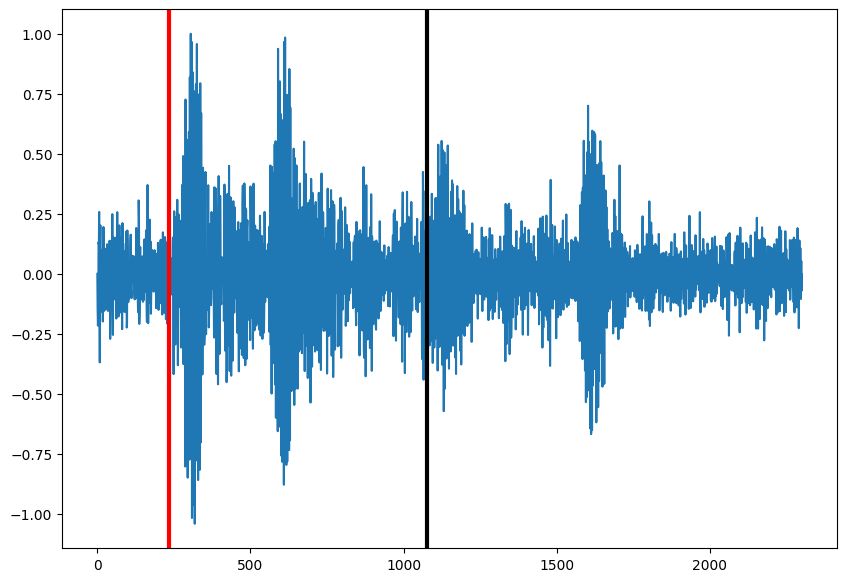

In [67]:
# all waveforms with a pick in the position 0 samples is an earthquake.
seisbench_data_ = data
number_plots_ = 1
plot_seisbench_data(seisbench_data = seisbench_data_, number_plots = number_plots_)

In [78]:
len(data)

890214

In [76]:
# Batch size to avoid memory overload, adjust as necessary
batch_size = 1000

# Function to process a batch of samples
def process_batch(indices):
    batch_results = []
    for index in indices:
        data_ind = data.get_sample(index)  # Retrieve the sample within the parallelized function
        batch_results.append(len(data_ind[0][0]))
    return batch_results

# Split the indices into batches
indices = np.array_split(range(len(data)), len(data) // batch_size)

# Process batches in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_batch)(batch) for batch in tqdm(indices)
)

# Flatten the list of results
results = [item for sublist in results for item in sublist]


100%|█████████████████████████████████████████| 890/890 [11:03<00:00,  1.34it/s]


In [80]:
indices[-1]

array([889214, 889215, 889216, 889217, 889218, 889219, 889220, 889221,
       889222, 889223, 889224, 889225, 889226, 889227, 889228, 889229,
       889230, 889231, 889232, 889233, 889234, 889235, 889236, 889237,
       889238, 889239, 889240, 889241, 889242, 889243, 889244, 889245,
       889246, 889247, 889248, 889249, 889250, 889251, 889252, 889253,
       889254, 889255, 889256, 889257, 889258, 889259, 889260, 889261,
       889262, 889263, 889264, 889265, 889266, 889267, 889268, 889269,
       889270, 889271, 889272, 889273, 889274, 889275, 889276, 889277,
       889278, 889279, 889280, 889281, 889282, 889283, 889284, 889285,
       889286, 889287, 889288, 889289, 889290, 889291, 889292, 889293,
       889294, 889295, 889296, 889297, 889298, 889299, 889300, 889301,
       889302, 889303, 889304, 889305, 889306, 889307, 889308, 889309,
       889310, 889311, 889312, 889313, 889314, 889315, 889316, 889317,
       889318, 889319, 889320, 889321, 889322, 889323, 889324, 889325,
      

In [88]:
# Count occurrences
print('Distribution of lengths for training data. Most of them are 2201 samples long, too few are 4601 samples long.')
counter = Counter(results)
# Sort by frequency in descending order
sorted_counts = sorted(counter.items(), key=lambda item: item[0], reverse=False)

# Print the counts
total = 0
ls_count = []
for word, count in sorted_counts:
    print(f'{word}: {count}')
    total += count
    ls_count.append(count)
print('Total: ', total)

Distribution of lengths for training data. Most of them are 2201 samples long, too few are 4601 samples long.
2201: 167963
2301: 226846
2401: 62418
2501: 71003
2601: 62519
2700: 3535
2701: 24139
2800: 3737
2801: 18786
2900: 14746
2901: 12726
3000: 12423
3001: 12625
3100: 13130
3101: 6161
3200: 22523
3201: 2424
3301: 55752
3401: 31411
3501: 13635
3601: 21210
3701: 9595
3801: 5454
3901: 9595
4001: 202
4100: 2121
4200: 1212
4300: 1111
4500: 707
4601: 505
Total:  890214


In [91]:
np.cumsum(np.array(ls_count)) / np.sum(np.array(ls_count))

array([0.1886771 , 0.44349898, 0.5136147 , 0.59337418, 0.66360336,
       0.66757431, 0.69469027, 0.69888813, 0.71999092, 0.73655548,
       0.75085092, 0.76480599, 0.77898797, 0.79373724, 0.80065804,
       0.8259587 , 0.82868164, 0.89130928, 0.92659405, 0.9419106 ,
       0.96573633, 0.97651464, 0.98264125, 0.99341956, 0.99364647,
       0.99602904, 0.99739052, 0.99863853, 0.99943272, 1.        ])